# Learning and Decision Making

## Laboratory 4: MNIST

In the end of the lab, you should save the notebook as `padi-lab4-groupXX.ipynb`, where the `XX` corresponds to your group number and should be submitted to the e-mail <adi.tecnico@gmail.com>. 

Make sure that the subject is of the form `[<group n.>] LAB <lab n.>`.

### 1. The MNIST dataset

The National Institute of Standards and Technology (NIST) published in 1995 a corpus for handprinted document and character recognition. The corpus originally contained 810,000 character images from 3,600 different writers. The MNIST ("Modified NIST") dataset was created from the original NIST dataset and contains a total of 70,000 normalized images ($28\times28$ pixels) containing handwritten digits. All images are grayscale and anti-aliased. 

---

In this lab, we work with a simplified version of the MNIST dataset, in order to have the algorithms run in a manageable amount of time. In such modified dataset, digit images have been pre-processed to $8\times 8$ images, where each pixel takes values between 0 and 16. The modified dataset is available in `scikit-learn` through its `datasets` module. We thus start by loading the digits dataset.

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

<IPython.core.display.Javascript object>


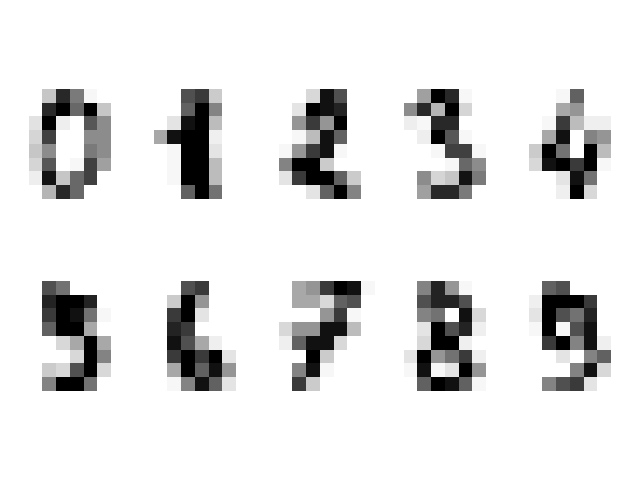

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as data

# Load dataset and print its description
digits = data.load_digits()
print(digits.DESCR)

# Get dimensions 
nP = digits.data.shape[0]
nF = digits.data.shape[1]

fig = plt.figure()

# Print sample digits
for i in range(10): 
    plt.subplot(2, 5, i + 1)
    idx = list(digits.target).index(i)
    plt.imshow(digits.images[idx], cmap='Greys')
    plt.axis('off')

fig.tight_layout()
plt.show()

In the first activities, you will prepare the dataset, before running any learning algorithms.

---

#### Activity 1.        

From the MNIST dataset, construct the training and test sets. The input data can be accessed as the attribute `data` in the dataset `digits`; the corresponding output data can be accessed as the attribute `target` in `digits`. To build the train and test sets, you can use the function `train_test_split` from the module `model_selection` of `scikit-learn`. Make sure that the test set corresponds to $1/7$th of the total number of samples. 

**Note:** Don't forget to import the necessary modules from `scikit-learn`. Also, for reproducibility, initialize the seed of the `train_test_split` function to a fixed number (e.g., 42).

---

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(digits['data'], digits['target'], test_size=1/7, random_state=42)

### 2. Principal component analysis (PCA)

Right now, each point in the dataset is represented by the pixel information, which roughly corresponds to $64$ features. In this activity, you will determine a small number of alternative features that manage to capture most of the relevant information contained in each picture but which provide a much more compact representation thereto. Such features correspond to the _principal components_ that you will compute next. PCA can be performed through the function `PCA`, in the `decomposition` module of `scikit-learn`. 

---

#### Activity 2.        

* Run PCA on the training set. To do this, you should first fit the PCA model to the train data and then use the resulting model to transform the data. For details, check the documentation for the function `PCA`.

* To grasp how much of the information in the data is contained in the different components, plot the _cumulative explained variance_ (in percentage) as a function of the number of components. The explained variance can be accessed via the attribute `explained_variance_` of your model.

**Note:** In general, before running PCA on some training set, you should _standardize_ the data to make sure that all inputs are centered and lie in the same range. To do this, you can use the function `StandardScaler` of the module `preprocessing` of `scikit-learn`.

---

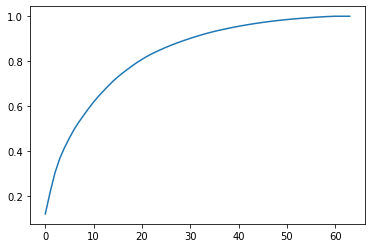

In [30]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data_train)
standard_data_train = scaler.transform(data_train)

pca = PCA().fit(standard_data_train)

cumulative_explained_variance = np.cumsum(pca.explained_variance_)
cumulative_explained_variance = cumulative_explained_variance / cumulative_explained_variance[-1]

plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance, '-')
plt.show()

Note how a small number of components explain around 90\% of the variance in the data. As such, it seems reasonable that we may rely only on those components as features to represent our data.

### 3. Impact of number of features on a Logistic Regression classifier

To clearly understand the implications of the adopted representation, you will now run an extensive test to investigate how the number of components may impact the performance of the classifier. 

---

#### Activity 3.        

Take the data in your training set and further split it in two sets, $D_T$ and $D_V$, where $D_T$ corresponds to $85\%$ of the training data and $D_V$ to the remaining $15\%$. You will use $D_T$ for training, and $D_V$ for validation. 

For $k\in\{5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64\}$,

* Run PCA with $k$ components on the data in $D_T$
* Transform the data in $D_T$ using the computed PCA
* Train a logistic regression classifier on the transformed data. Use $C=100$, the `'newton-cg'` solver, and set the multi_class option to `'auto'`
* Compute the error in $D_T$ and in $D_V$

Repeat the _whole process_ (including the split of $D_T$ and $D_V$) 40 times.

**Note 1:** Don't forget that, in order to run PCA, you should standardize the data once again; you should not use the standardized data from Activity 2, since it has seen the whole data in $D_T$ and $D_V$. 

**Note 2:** Also, don't forget that, in order to run your classifier with the data in $D_V$, you must transform it with the PCA fit to $D_T$.

**Note 3:** The whole process may take a while, so don't despair. The logistic regression classifier can be accessed by importing `LogisticRegression` from `sklearn.linear_model`. To compute the error of a classifier, you can use the `accuracy_score` function from `sklearn.metrics`.

---

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

components = [i * 5 for i in range(1, 13)] + [64]
averages_t = {}
averages_v = {}

for k in components:
    averages_t[k] = 0
    averages_v[k] = 0

for i in range(40):
    Dt, Dv, Tt, Tv = train_test_split(data_train, target_train, test_size=.15)
    
    scaler = StandardScaler().fit(Dt)
    standard_Dt = scaler.transform(Dt)
    standard_Dv = scaler.transform(Dv)

    for k in components:
        pca = PCA(n_components=k).fit(standard_Dt)
        pca_Dt = pca.transform(standard_Dt)
        pca_Dv = pca.transform(standard_Dv)
        
        lr = LogisticRegression(C=1.0, solver='newton-cg', multi_class='auto').fit(pca_Dt, Tt)
        
        accuracy_Dt = 1 - accuracy_score(Tt, lr.predict(pca_Dt))
        accuracy_Dv = 1 - accuracy_score(Tv, lr.predict(pca_Dv))
        
        averages_t[k] = (averages_t[k]*i + accuracy_Dt)/(i+1)
        averages_v[k] = (averages_v[k]*i + accuracy_Dv)/(i+1)
        
        print(f'Iteration {i} k={k}')
        print(f'Error in Dt {accuracy_Dt}')
        print(f'Error in Dv {accuracy_Dv}')

Iteration 0 k=5
Error in Dt 0.18411000763941943
Error in Dv 0.1558441558441559
Iteration 0 k=10
Error in Dt 0.106951871657754
Error in Dv 0.11255411255411252
Iteration 0 k=15
Error in Dt 0.040488922841864006
Error in Dv 0.06493506493506496
Iteration 0 k=20
Error in Dt 0.02291825821237581
Error in Dv 0.06060606060606055
Iteration 0 k=25
Error in Dt 0.012987012987012991
Error in Dv 0.05627705627705626
Iteration 0 k=30
Error in Dt 0.006875477463712754
Error in Dv 0.04329004329004327
Iteration 0 k=35
Error in Dt 0.006111535523300238
Error in Dv 0.04761904761904767
Iteration 0 k=40
Error in Dt 0.005347593582887722
Error in Dv 0.038961038961038974
Iteration 0 k=45
Error in Dt 0.0030557677616500634
Error in Dv 0.04329004329004327
Iteration 0 k=50
Error in Dt 0.0007639419404125158
Error in Dv 0.03463203463203468
Iteration 0 k=55
Error in Dt 0.0007639419404125158
Error in Dv 0.030303030303030276
Iteration 0 k=60
Error in Dt 0.0007639419404125158
Error in Dv 0.030303030303030276
Iteration 0 k=64

---

#### Activity 4.

Plot the average training and validation error from Activity 3 as a function of $k$. Explain the differences observed between the two curves.

---

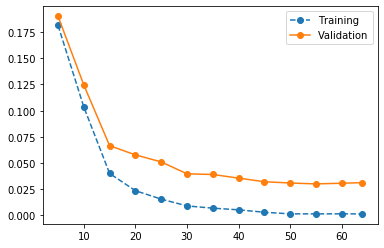

In [32]:
plt.plot(components, list(averages_t.values()), 'o--', label='Training')
plt.plot(components, list(averages_v.values()), 'o-', label='Validation')

plt.legend()
plt.show()

<span style="color:blue">The blue curve corresponds to the error rate variation as we iterate over the number of selected features from Traning dataset. Meanwhile, the orange curve represents the same for the validation dataset. The difference between these two curves is that the blue curve can't be used to acess the actual performance of the Logistic regression and the orange curve can. It makes sense that the orange curve has lower accuracy scores overall as the samples used were never seen during the training process.</span>

### 4. Comparison of different classifiers

In Activity 4 you investigated the impact of the number of features on the performance of the Logistic Regression algorithm. You will now compare the performance of the best logistic regression algorithm with another algorithm from the literature.

---

#### Activity 5.        

* Repeat Activity 3 but now using a 5-Nearest Neighbors classifier instead of a Logistic Regression. 
* Plot the average training and validation error as a function of 𝑘.

**Note:** Again, the whole process may take a while, so don't despair. The kNN classifier can be accessed by importing `KNeighborsClassifier` from `sklearn.neighbors`.

---

Iteration 0 k=5
Error in Dt 0.09090909090909094
Error in Dv 0.16450216450216448
Iteration 0 k=10
Error in Dt 0.04125286478227652
Error in Dv 0.09523809523809523
Iteration 0 k=15
Error in Dt 0.02062643239113826
Error in Dv 0.06493506493506496
Iteration 0 k=20
Error in Dt 0.01680672268907568
Error in Dv 0.03463203463203468
Iteration 0 k=25
Error in Dt 0.015278838808250539
Error in Dv 0.017316017316017285
Iteration 0 k=30
Error in Dt 0.016042780748663055
Error in Dv 0.030303030303030276
Iteration 0 k=35
Error in Dt 0.015278838808250539
Error in Dv 0.038961038961038974
Iteration 0 k=40
Error in Dt 0.014514896867838023
Error in Dv 0.030303030303030276
Iteration 0 k=45
Error in Dt 0.013750954927425507
Error in Dv 0.025974025974025983
Iteration 0 k=50
Error in Dt 0.014514896867838023
Error in Dv 0.02164502164502169
Iteration 0 k=55
Error in Dt 0.013750954927425507
Error in Dv 0.025974025974025983
Iteration 0 k=60
Error in Dt 0.012987012987012991
Error in Dv 0.025974025974025983
Iteration 0 k=

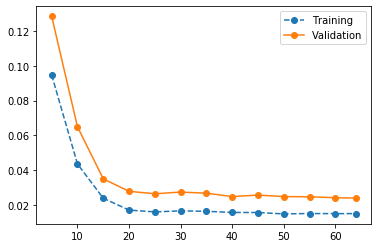

In [36]:
from sklearn.neighbors import KNeighborsClassifier

averages_t_knn = {}
averages_v_knn = {}

for k in components:
    averages_t_knn[k] = 0
    averages_v_knn[k] = 0

for i in range(40):
    Dt, Dv, Tt, Tv = train_test_split(data_train, target_train, test_size=.15)

    scaler = StandardScaler().fit(Dt)
    standard_Dt = scaler.transform(Dt)
    standard_Dv = scaler.transform(Dv)
    
    for k in components:
        pca = PCA(n_components=k).fit(standard_Dt)
        pca_Dt = pca.transform(standard_Dt)
        pca_Dv = pca.transform(standard_Dv)
        
        knc = KNeighborsClassifier(n_neighbors=5).fit(pca_Dt, Tt)
        
        accuracy_Dt = 1 - accuracy_score(Tt, knc.predict(pca_Dt))
        accuracy_Dv = 1 - accuracy_score(Tv, knc.predict(pca_Dv))
        
        averages_t_knn[k] = (averages_t_knn[k]*i + accuracy_Dt)/(i+1)
        averages_v_knn[k] = (averages_v_knn[k]*i + accuracy_Dv)/(i+1)
        
        print(f'Iteration {i} k={k}')
        print(f'Error in Dt {accuracy_Dt}')
        print(f'Error in Dv {accuracy_Dv}')
        
plt.plot(components, list(averages_t_knn.values()), 'o--', label='Training')
plt.plot(components, list(averages_v_knn.values()), 'o-', label='Validation')

plt.legend()
plt.show()

---

#### Activity 6.        

Taking into consideration the results from Activities 3 and 5, select the classifier and number of features that you believe is best and

* Compute the performance of your selected classifier on the test data. 
* Comment whether the performance on the test data matches what you expected, based on the results from activities 3 and 5.

**Note:** When computing the performance of your selected classifier, you should re-train it using the whole training data.

---

In [35]:
scaler = StandardScaler().fit(data_train)
standard_data_train = scaler.transform(data_train)
standard_data_test = scaler.transform(data_test)

pca = PCA(n_components=20).fit(standard_data_train)
pca_data_train = pca.transform(standard_data_train)
pca_data_test = pca.transform(standard_data_test)

knc = KNeighborsClassifier(n_neighbors=5).fit(pca_data_train, target_train)

accuracy_train = 1 - accuracy_score(target_train, knc.predict(pca_data_train))
accuracy_test = 1 - accuracy_score(target_test, knc.predict(pca_data_test))

print(f'Training error: {accuracy_train}')
print(f'Testing error: {accuracy_test}')

Training error: 0.014285714285714235
Testing error: 0.035019455252918275


<span style="color:blue">Based on the results from Activities 3 and 5 we are not able to forsee exactly how the model will behave with the test data. But the error values from the validation dataset help us understand how the accuracy changes with accordance with the number of components. According to the results obtained, we can observe that the kNN classifier presents a smaller error value. Also, at around 20 components, the classifier achieves its smallest value. Since the goal is to obtain the "simplest" system, we should choose the classifier that presents the smallest error values using the fewer components possible. So with that in mind, we chose the kNN classifier with 20 components. The result obtained in Activity 6 lies within the expected values.</span>